In [1]:
#ツイートのテキスト読み込み
test = open("RNN_tweet/Datas/N_extract_tweet.txt", "r", encoding="utf-8")
lines = test.readlines()
test.close()
print(len(lines))

#ラベル読み込み
test = open("RNN_tweet/Datas/label.txt", "r", encoding="utf-8")
label = test.readlines()
test.close()
print(len(label))

10000
10000


In [2]:
from gensim.models import word2vec

embeddings_model = word2vec.Word2Vec.load('RNN_tweet/Datas/noun_tweet.model')

G:\ganda\conda\tensorflow_test\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical

maxlen = 200
training_samples = 8000 # training data 80 : validation data 20
validation_samples = len(lines) - training_samples
max_words = 20000

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
data = pad_sequences(sequences, maxlen=maxlen)

word_index = tokenizer.word_index
num_words = len(word_index)

embedding_matrix = np.zeros((num_words+1, 200))
for word, i in word_index.items():
    if word in embeddings_model.wv.index2word:
        embedding_matrix[i] = embeddings_model[word]
        
# バイナリの行列に変換
categorical_labels = to_categorical(label)
labels = np.asarray(categorical_labels)

# 行列をランダムにシャッフルする
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.
G:\ganda\conda\tensorflow_test\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [4]:
import keras.backend as K
from functools import partial

def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2), K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [5]:
def weight_variable(shape):
    return K.truncated_normal(shape, stddev = 0.01)

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.utils import plot_model

model = Sequential()
model.add(Embedding(num_words+1, 200, weights=[embedding_matrix], trainable=False))
model.add(Dropout(0.5))
model.add(LSTM(1024, kernel_initializer=weight_variable))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
#opt = Adam(lr=1e-4, beta_1 = 0.9, beta_2 = 0.999)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc', macro_precision, macro_recall, macro_f_measure])
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='N_method2_LSTM1024_model.png')

early_stopping = EarlyStopping(patience=5, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         3770600   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              5017600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 8,790,250
Trainable params: 5,019,650
Non-trainable params: 3,770,600
_________________________________________________________________


In [7]:
history = model.fit(x_train, y_train,
                    epochs=100, 
                    batch_size=300,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.5676 - acc: 0.6764 - macro_precision: 0.6994 - macro_recall: 0.6754 - macro_f_measure: 0.6870 - val_loss: 0.5162 - val_acc: 0.7300 - val_macro_precision: 0.7311 - val_macro_recall: 0.7304 - val_macro_f_measure: 0.7308
Epoch 2/100
8000/8000 [==============================] - 22s 3ms/step - loss: 0.8577 - acc: 0.6834 - macro_precision: 0.6783 - macro_recall: 0.6863 - macro_f_measure: 0.6788 - val_loss: 0.5741 - val_acc: 0.6585 - val_macro_precision: 0.6727 - val_macro_recall: 0.6591 - val_macro_f_measure: 0.6658
Epoch 3/100
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5453 - acc: 0.6996 - macro_precision: 0.7081 - macro_recall: 0.7001 - macro_f_measure: 0.7041 - val_loss: 0.5161 - val_acc: 0.7260 - val_macro_precision: 0.7313 - val_macro_recall: 0.7267 - val_macro_f_measure: 0.7290
Epoch 4/100
8000/8000 [==============================] - 2

In [8]:
model.save('N_method2_model_LSTM1024.h5')

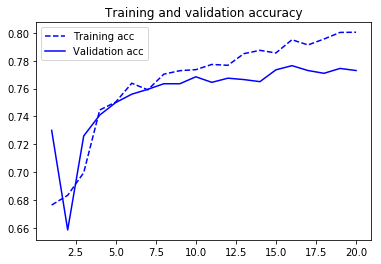

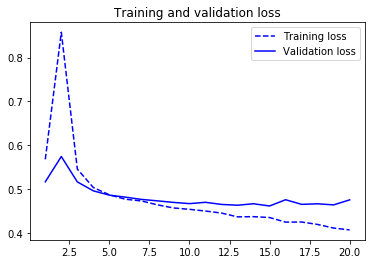

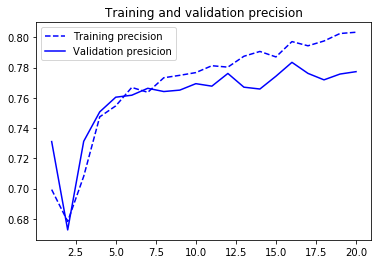

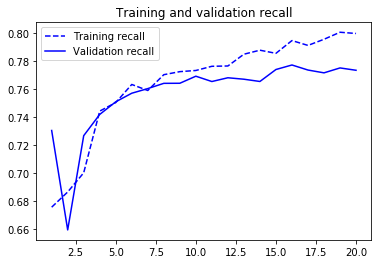

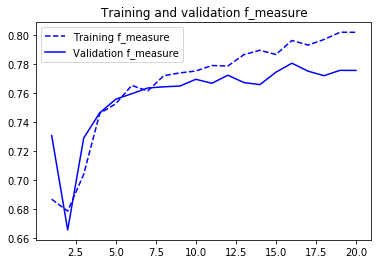

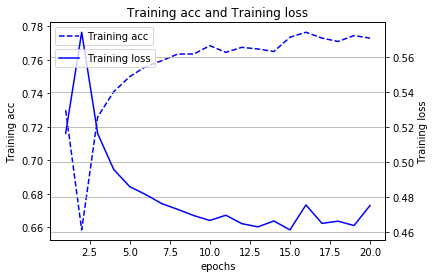

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['macro_precision']
val_precision = history.history['val_macro_precision']
recall = history.history['macro_recall']
val_recall = history.history['val_macro_recall']
f_measure = history.history['macro_f_measure']
val_f_measure = history.history['val_macro_f_measure']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("RNN_tweet/Figs/N_method2/N_acc.png")

plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("RNN_tweet/Figs/N_method2/N_loss.png")

plt.figure()

plt.plot(epochs, precision, 'b--', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation presicion')
plt.title('Training and validation precision')
plt.legend()
plt.savefig("RNN_tweet/Figs/N_method2/N_precision.png")

plt.figure()

plt.plot(epochs, recall, 'b--', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.savefig("RNN_tweet/Figs/N_method2/N_recall.png")

plt.figure()

plt.plot(epochs, f_measure, 'b--', label='Training f_measure')
plt.plot(epochs, val_f_measure, 'b', label='Validation f_measure')
plt.title('Training and validation f_measure')
plt.legend()
plt.savefig("RNN_tweet/Figs/N_method2/N_f_measure.png")

fig = plt.figure()

ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Training acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Training loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Training acc and Training loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Training acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Training loss')

plt.savefig("RNN_tweet/Figs/N_method2/acc_loss.png")
plt.show()
